# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Описание проекта**

Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Описание данных**

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
- Contract — договор с юридическим лицом;
- Group — групповой заезд;
- Transient — не связано с договором или групповым заездом;
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
- SC — нет дополнительных опций;
- BB — включён завтрак;
- HB — включён завтрак и обед;
- FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

**Задача:**

Разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Дополнительные условия:**

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
На разработку системы прогнозирования заложен бюджет — 400 000 руб. При этом необходимо учесть, что внедрение модели должно окупиться. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve
import time
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None



import warnings
warnings.filterwarnings('ignore')


Открываем файлы от заказчика:

У нас имеется два дата-сета: первый для обучения модели, назовем его hotel_train; второй для итогового тестирования разработанной модели, назовем его hotel_test:

In [2]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')
display(hotel_train.head(2))
display(hotel_test.head(2))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4


Данные успешно загружены.

Посмотрим общую информацию о данных и есть ли пропуски:

In [3]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
hotel_train.isna().mean()

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

Дата-сет имеет 65229 строк и 25 колонок. Пропусков нет.

In [5]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [6]:
hotel_test.isna().mean()

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

Дата-сет имеет 32412 строк и 25 колонок. Пропусков нет.

### Шаг 2. Предобработка и исследовательский анализ данных

Заменим типы данных в колонках 'children','adults','babies' на int

In [7]:
columns = ['lead_time','children','adults','babies']

In [8]:
for i in columns:
    hotel_train[i] = hotel_train[i].astype(int)

In [9]:
hotel_train.dtypes

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

Проделаем тоже самое для тестовой выборки

In [10]:
for i in columns:
    hotel_test[i] = hotel_test[i].astype(int)

In [11]:
hotel_test.dtypes

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

Типы данных изменены

Проверим датасеты на дубликаты:

In [12]:
hotel_train.duplicated().sum()

0

In [13]:
hotel_test.duplicated().sum()

0

In [14]:
# удалим столбец id 
hotel_train = hotel_train.drop('id', axis = 1)
hotel_test = hotel_test.drop('id', axis = 1)

In [15]:
hotel_train.head(2)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,2015,July,27,1,0,1,1,0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14,2015,July,27,1,0,2,2,0,...,0,0,0,A,0,0,Transient,0,1,2


In [16]:
# Проверим датасеты на дубликаты после удаления id:
hotel_train.duplicated().sum()

21377

In [17]:
hotel_test.duplicated().sum()

7717

In [18]:
hotel_train[hotel_train.duplicated(keep='first')]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
13,0,72,2015,July,27,1,2,4,2,0,...,0,0,0,A,1,0,Transient,0,1,6
85,1,5,2015,July,28,5,1,0,2,0,...,0,0,0,D,0,0,Transient,0,0,1
115,0,0,2015,July,28,7,0,1,1,0,...,0,0,0,A,0,0,Transient,0,3,1
127,1,1,2015,July,28,8,0,1,2,0,...,0,0,0,A,0,0,Transient,0,1,1
219,0,40,2015,July,29,13,1,4,2,0,...,0,0,0,D,0,0,Transient,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65188,0,269,2016,December,53,29,2,3,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65189,0,269,2016,December,53,29,2,3,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65192,0,269,2016,December,53,29,2,3,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,5
65193,0,269,2016,December,53,29,2,3,1,0,...,0,0,0,A,0,0,Transient-Party,0,1,5


In [19]:
hotel_test[hotel_test.duplicated(keep='first')]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2,1,62,2017,January,1,1,2,2,2,0,...,0,0,0,A,0,0,Transient,0,1,4
34,1,113,2017,January,2,8,1,0,2,0,...,0,0,0,A,0,0,Transient,0,0,1
59,1,40,2017,January,3,16,1,2,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,3
61,1,40,2017,January,3,16,1,2,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,3
63,1,40,2017,January,3,16,1,2,1,0,...,0,0,0,A,0,0,Transient-Party,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32377,0,186,2017,August,35,31,0,3,2,0,...,0,0,0,D,0,0,Transient,0,2,3
32380,0,63,2017,August,35,31,0,3,3,0,...,0,0,0,D,0,0,Transient-Party,0,2,3
32381,0,63,2017,August,35,31,0,3,3,0,...,0,0,0,D,0,0,Transient-Party,0,2,3
32382,0,63,2017,August,35,31,0,3,3,0,...,0,0,0,D,0,0,Transient-Party,0,2,3


Наш набор данных содержит дубликаты. Однако возможно, что несколько бронирований с одинаковыми функциями были сделаны в один и тот же день. Поскольку у нас нет такого столбца, как "идентификатор бронирования", мы не можем с уверенностью сказать, что это настоящие дубликаты, что делает удаление этих "дубликатов" сомнительным. Поэтому оставим всё как есть

Исходный набор данных предоставляет дату прибытия клиента с указанием дня, месяца и года, каждый в отдельной функции. Для целей анализа проще объединить все эти элементы в одну функцию arrival_date_full

In [20]:
hotel_train['arrival_date_full'] = hotel_train['arrival_date_year'].astype(str) + "-" + hotel_train['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + hotel_train['arrival_date_day_of_month'].astype(str)
hotel_train['arrival_date_full'] = pd.to_datetime(hotel_train['arrival_date_full'], format="%Y-%m-%d")

In [21]:
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full
0,0,7,2015,July,27,1,0,1,1,0,...,0,0,A,0,0,Transient,0,0,1,2015-07-01
1,0,14,2015,July,27,1,0,2,2,0,...,0,0,A,0,0,Transient,0,1,2,2015-07-01
2,0,0,2015,July,27,1,0,2,2,0,...,0,0,C,0,0,Transient,0,0,2,2015-07-01
3,0,9,2015,July,27,1,0,2,2,0,...,0,0,C,0,0,Transient,0,1,2,2015-07-01
4,1,85,2015,July,27,1,0,3,2,0,...,0,0,A,0,0,Transient,0,1,3,2015-07-01


Сделаем то же самое для тестового набора данных

In [22]:
hotel_test['arrival_date_full'] = hotel_test['arrival_date_year'].astype(str) + "-" + hotel_test['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + hotel_test['arrival_date_day_of_month'].astype(str)
hotel_test['arrival_date_full'] = pd.to_datetime(hotel_test['arrival_date_full'], format="%Y-%m-%d")

In [23]:
hotel_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full
0,1,74,2017,January,1,1,1,0,2,0,...,0,0,A,0,0,Transient,0,0,1,2017-01-01
1,1,62,2017,January,1,1,2,2,2,0,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
2,1,62,2017,January,1,1,2,2,2,0,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
3,1,71,2017,January,1,1,2,2,1,0,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
4,1,172,2017,January,1,1,2,5,2,0,...,0,0,A,0,0,Transient,0,0,7,2017-01-01


Посмотрим уникальные значения колонки required_car_parking_spaces — количество мест для автомобилей:

In [24]:
print('Уникальные значения колонки required_car_parking_spaces дата-сета  hotel_train: ', hotel_train['required_car_parking_spaces'].value_counts())
print('Уникальные значения колонки required_car_parking_spaces дата-сета  hotel_test:', hotel_test['required_car_parking_spaces'].value_counts())

Уникальные значения колонки required_car_parking_spaces дата-сета  hotel_train:  0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64
Уникальные значения колонки required_car_parking_spaces дата-сета  hotel_test: 0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64


Строк с 2 и более местами слишком мало, чтобы делать по ним прогноз. Удалим их.

In [25]:
hotel_train = hotel_train.loc[hotel_train['required_car_parking_spaces'] < 2]

In [26]:
hotel_train['required_car_parking_spaces'].value_counts()

0    61547
1     3670
Name: required_car_parking_spaces, dtype: int64

In [27]:
hotel_test = hotel_test.loc[hotel_test['required_car_parking_spaces'] < 2]

In [28]:
hotel_test['required_car_parking_spaces'].value_counts()

0    30935
1     1468
Name: required_car_parking_spaces, dtype: int64

In [29]:
# проверим уникальные значения в столбце бронирований с младенцами
hotel_train['babies'].value_counts()

0     64765
1       447
2         3
9         1
10        1
Name: babies, dtype: int64

In [30]:
# В датасете есть бронирования с 9,10 младенцами, а это явно аномалия, поэтому лучше удалим эти значения
hotel_train = hotel_train.loc[hotel_train['babies'] < 3]

In [31]:
hotel_train['babies'].value_counts()

0    64765
1      447
2        3
Name: babies, dtype: int64

In [32]:
hotel_test['babies'].value_counts()

0    32228
1      171
2        4
Name: babies, dtype: int64

In [33]:
# Проверка на пустоты перед значением и после значения в столбцах object
for column in hotel_train.columns:
    if hotel_train[column].dtypes == 'O':
        hotel_train[column] = hotel_train[column].str.strip()

In [34]:
for column in hotel_test.columns:
    if hotel_test[column].dtypes == 'O':
        hotel_test[column] = hotel_test[column].str.strip()

Проверим на наличие неявных дубликатов столбцы, содержащие категориальные переменные. Начнем со столбца meal. Он должен содержать только 4 значения: SC, BB, HB, FB. Выведем, уникальные значения в таблицах при помощи метода unique():

In [35]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [36]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [37]:
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [38]:
hotel_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

In [39]:
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [40]:
hotel_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [41]:
hotel_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [42]:
hotel_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

In [43]:
hotel_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [44]:
hotel_test['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

In [45]:
hotel_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [46]:
hotel_test['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

Категориальные столбцы не содержат неявных дубликатов

Судя по описанию, total_nights — это сумма stays_in_week_nights и stays_in_weekend_nights, все три признака нам не нужны, оставим только total_nights

In [47]:
hotel_train = hotel_train.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis = 1)
hotel_test = hotel_test.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis = 1)

In [48]:
display(hotel_train)
display(hotel_test)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full
0,0,7,2015,July,27,1,1,0,0,BB,...,0,0,A,0,0,Transient,0,0,1,2015-07-01
1,0,14,2015,July,27,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,1,2,2015-07-01
2,0,0,2015,July,27,1,2,0,0,BB,...,0,0,C,0,0,Transient,0,0,2,2015-07-01
3,0,9,2015,July,27,1,2,0,0,FB,...,0,0,C,0,0,Transient,0,1,2,2015-07-01
4,1,85,2015,July,27,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,1,3,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,0,23,2016,December,53,30,2,0,0,BB,...,0,0,D,0,0,Transient,0,2,6,2016-12-30
65225,0,53,2016,December,53,31,2,0,0,HB,...,0,0,D,0,0,Transient,0,3,5,2016-12-31
65226,0,7,2016,December,53,31,2,0,0,BB,...,0,0,D,0,0,Transient,0,1,6,2016-12-31
65227,0,17,2016,December,53,30,2,0,0,SC,...,0,0,A,0,0,Transient,0,1,7,2016-12-30


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full
0,1,74,2017,January,1,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,0,1,2017-01-01
1,1,62,2017,January,1,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
2,1,62,2017,January,1,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
3,1,71,2017,January,1,1,1,0,0,BB,...,0,0,A,0,0,Transient,0,1,4,2017-01-01
4,1,172,2017,January,1,1,2,0,0,BB,...,0,0,A,0,0,Transient,0,0,7,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,0,164,2017,August,35,31,2,0,0,BB,...,0,0,A,0,0,Transient,0,0,6,2017-08-31
32408,0,21,2017,August,35,30,2,0,0,BB,...,0,0,A,0,0,Transient,0,2,7,2017-08-30
32409,0,23,2017,August,35,30,2,0,0,BB,...,0,0,A,0,0,Transient,0,0,7,2017-08-30
32410,0,34,2017,August,35,31,2,0,0,BB,...,0,0,D,0,0,Transient,0,4,7,2017-08-31


**Исследование целевого признака (is_canceled):**

In [49]:
hotel_train['is_canceled'].value_counts()

0    41171
1    24044
Name: is_canceled, dtype: int64

В колонке имются два уникальных значения "0" и "1". "1" означает, что клиент отменил заказ.

**Визуализируем процент отмененных и не отмененных бронирований:**

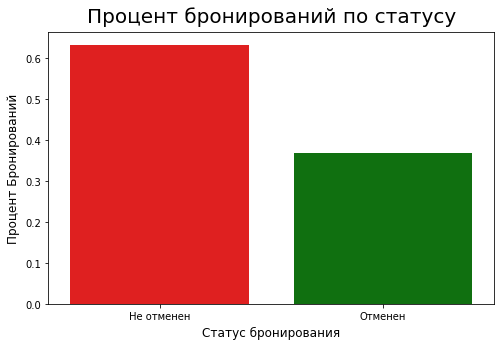

In [50]:
plt.figure(figsize=(8,5)) 
plt.title("Процент бронирований по статусу", fontsize = 20, pad = 10)
sns.barplot(x=hotel_train['is_canceled'].unique(), y=hotel_train['is_canceled'].value_counts(normalize=True), palette=['red', 'green'])
plt.xlabel("Статус бронирования", fontsize = 12, labelpad = 5)
plt.ylabel("Процент Бронирований", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])
plt.show()

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: хорошо, что обращаешь внимание на дисбаланс классов!</div>

Посмотрим корреляцию признаков

<AxesSubplot:>

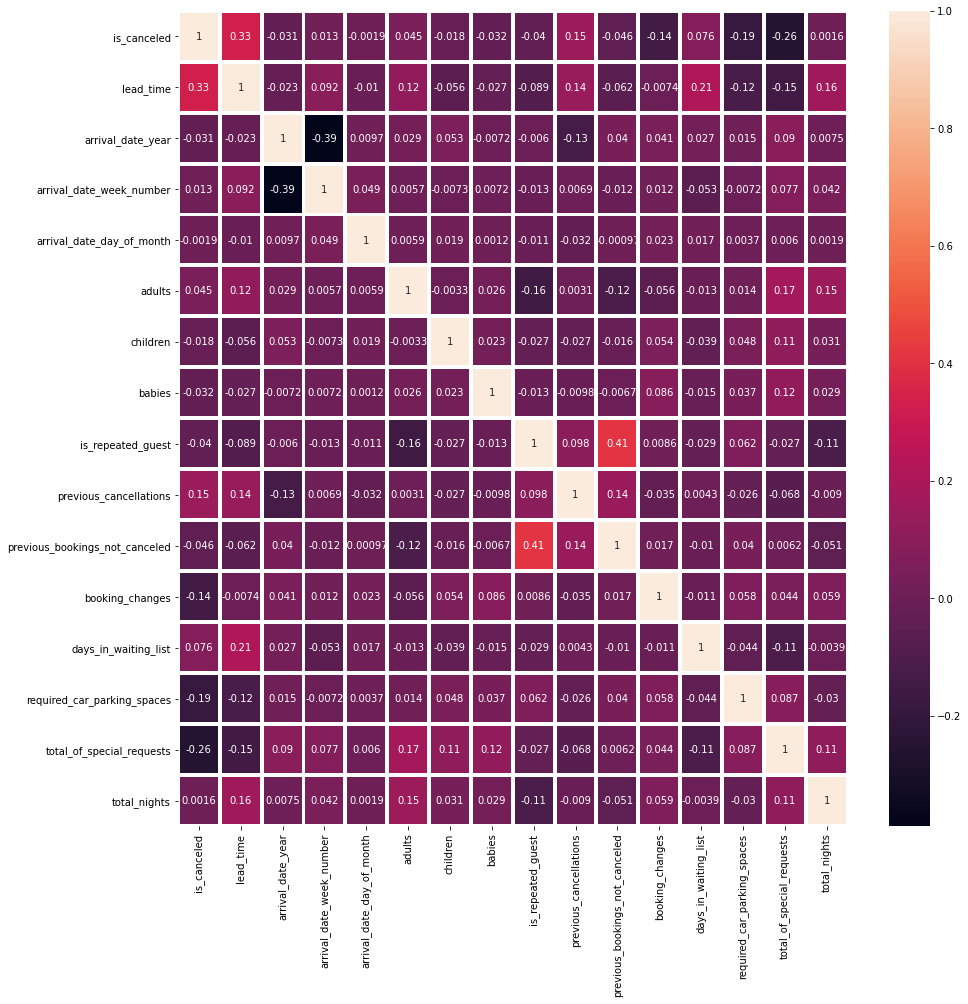

In [51]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
sns.heatmap(hotel_train.corr(), annot=True, linewidths=3, linecolor='white')

**Итак, отмена заказа коррелирует наиболее с четырьмя признаками:**

- Количество дней между датой бронирования и датой прибытия (lead time) наиболее тесно связано с тем, отменено бронирование или нет. Чем больше количество дней между моментом оформления бронирования и предполагаемой датой прибытия у клиентов появляется больше времени для отмены бронирования и больше времени для возникновения непредвиденных обстоятельств, срывающих планы поездок.

- Интересно, что количество специальных отметок (total_of_special_requests) является второй функцией, которая наиболее сильно коррелирует с отменой бронирования. По мере увеличения количества особых запросов вероятность отмены бронирования уменьшается. Это говорит о том, что взаимодействие с отелем до прибытия и ощущение, что их потребности услышаны, может снизить вероятность отмены бронирования клиентом.

- Необходимость места для автомобиля (requires_car_parking_spaces) является третьим признаком, который наиболее сильно коррелирует с отменой бронирования. Клиенты приезжающие на собственном автомобиле чувствуют себя более комфортно, если у них есть возможность припарковать свой автомобиль безопасно и на парковке отеля.

- Количество изменений параметров заказа (booking_changes) так же коррелирует с отменой. Вероятно когда клиент многократно меняет параметры, он колеблется в принятии решения.

Так же можно заметить, что предыдущая история отмены бронирования клиента (измеряемая количеством предыдущих отмен(previous_cancellations)) в большей степени коррелирует с тем, будет ли отменено текущее бронирование, чем предыдущая история клиента с отелем (измеряемая количеством предыдущих бронирований, которые не были отменены (previous_bookings_not_canceled), независимо от того, является ли клиент постоянным гостем(is_repeated_guest).

**Визуализация количества дней между датой бронирования и датой прибытия отмененных и не отмененных бронирований:**

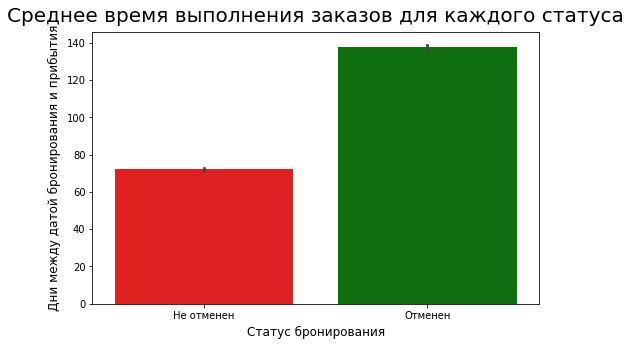

In [52]:
plt.figure(figsize=(8,5)) 
plt.title("Среднее время выполнения заказов для каждого статуса", fontsize = 20, pad = 10)
sns.barplot(x=hotel_train['is_canceled'], y=hotel_train['lead_time'], palette=['red', 'green'])
plt.xlabel("Статус бронирования", fontsize = 12, labelpad = 5)
plt.ylabel("Дни между датой бронирования и прибытия", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен']);
plt.show()

**Визуализация количество специальных отметок для отмененных и не отмененных бронирований:**

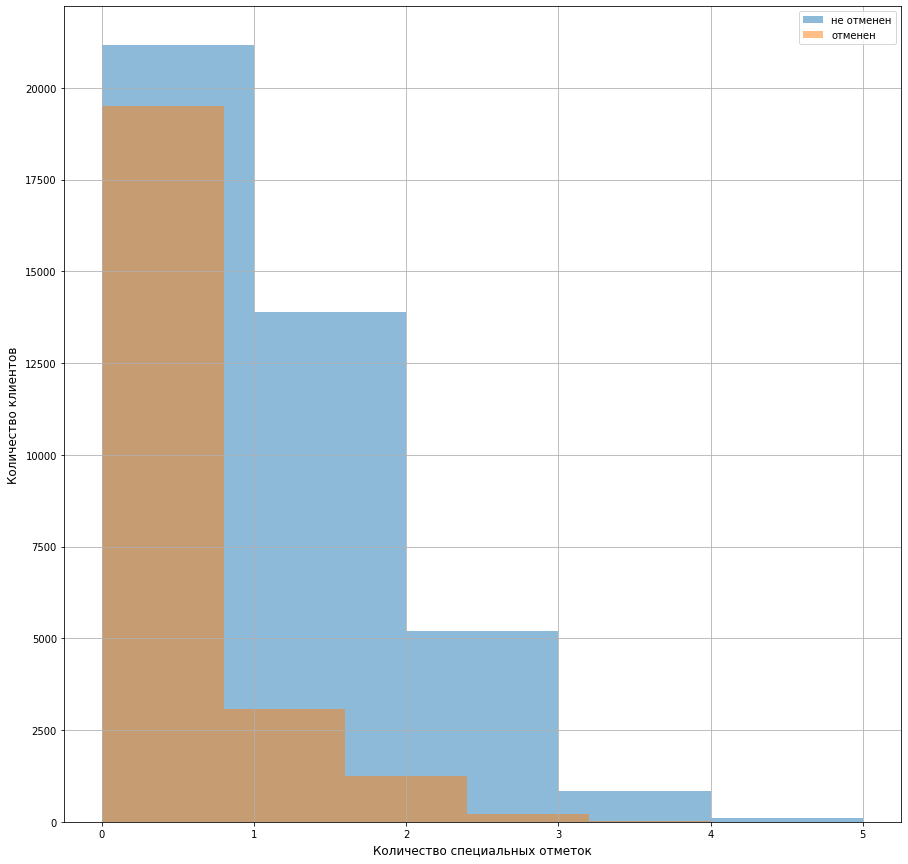

In [53]:
hotel_train.groupby('is_canceled')['total_of_special_requests'].hist(bins=5, alpha=0.5)
plt.xlabel('Количество специальных отметок',fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов',fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

Из графика можно увидеть, что как и предполагалось выше, по мере увеличения количества особых запросов вероятность отмены бронирования уменьшается.

**Визуализируем необходимость места для автомобиля (requires_car_parking_spaces) и количество отмен бронирования:**

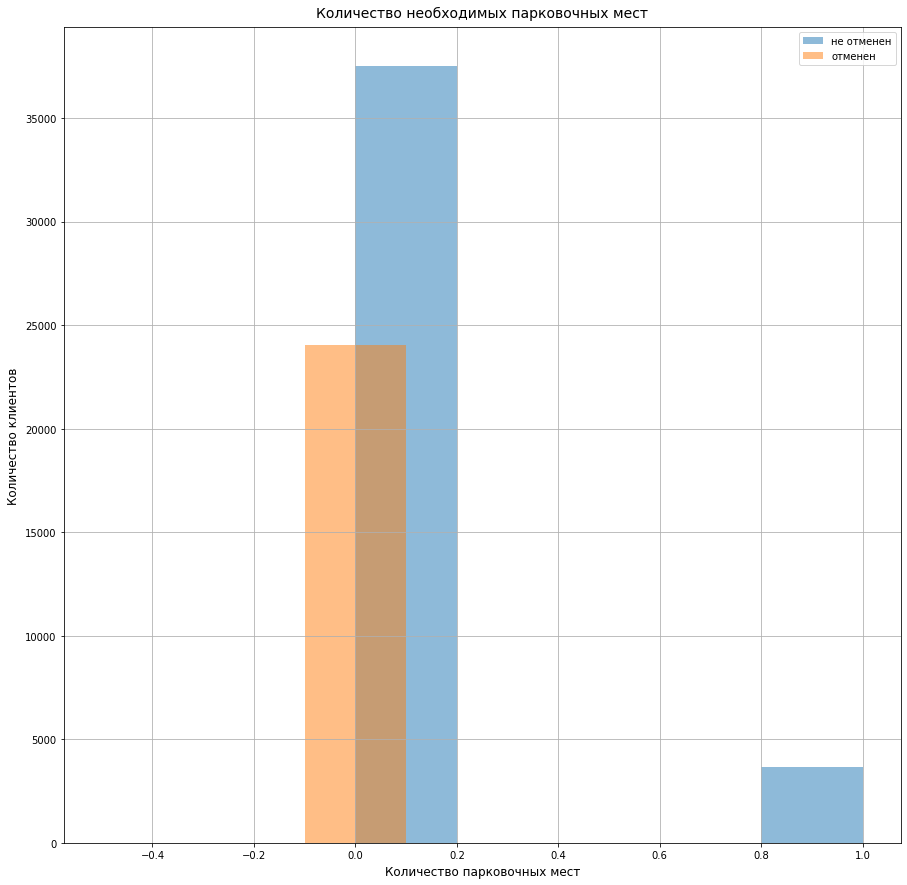

In [54]:
hotel_train.groupby('is_canceled')['required_car_parking_spaces'].hist(bins=5, alpha=0.5)
plt.title('Количество необходимых парковочных мест', fontsize = 14, pad = 10)
plt.xlabel('Количество парковочных мест', fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов', fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

В среднем клиентам, которые не отменяют свои бронирования, как правило, требуется больше парковочных мест. Как и в случае с количеством особых запросов, было бы разумно, что чем больше клиент взаимодействует с отелем (отправляя запрос на место для парковки), тем меньше вероятность того, что он отменит. Возможно добавление парковочных мест может помочь сократить количество отмен.

**Посмотрим есть ли выбросы в данных:**

In [55]:
hotel_train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000,65215.000000
mean,0.368688,96.333528,2015.719006,31.340765,15.847688,1.836587,0.074875,0.006946,0.027156,0.128943,0.107736,0.194142,3.335138,0.056275,0.512658,3.049804
std,0.482453,96.127472,0.449488,13.463861,8.747801,0.480259,0.334238,0.083607,0.162540,0.965427,1.326779,0.593550,18.241498,0.230455,0.752495,1.738079
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,2015.000000,21.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,2016.000000,34.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,3.000000,2.000000,1.000000,26.000000,58.000000,17.000000,259.000000,1.000000,5.000000,10.000000


Проверим столбцы: days_in_waiting_list,lead_time, в которых слишком большие максимальные значения:

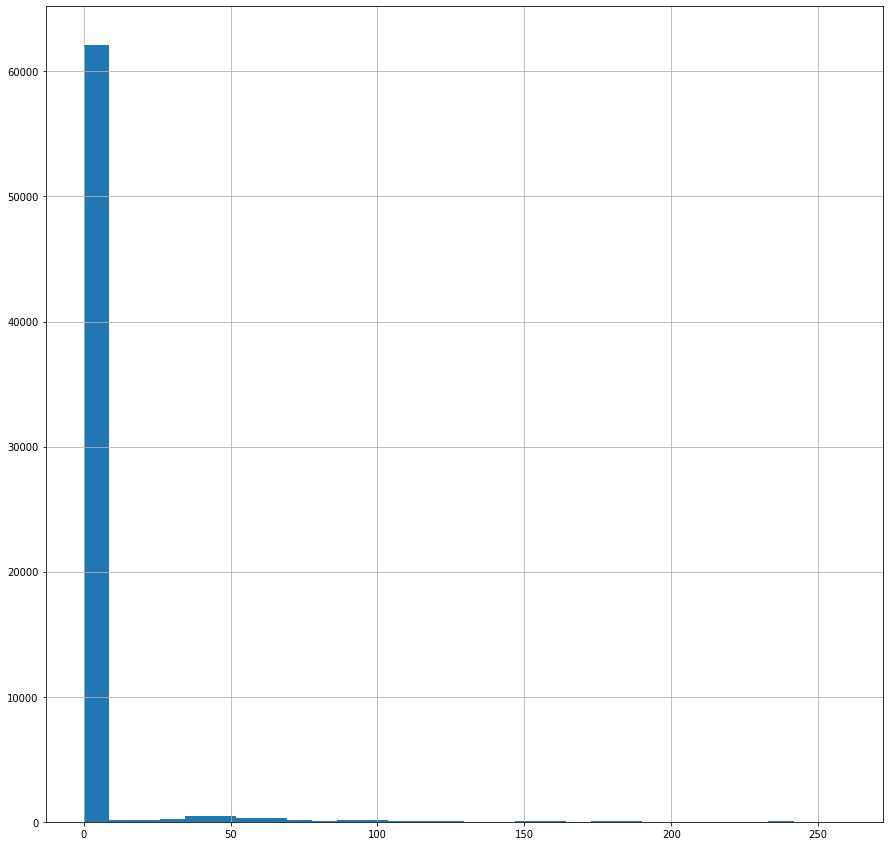

In [56]:
hotel_train['days_in_waiting_list'].hist(bins=30)
plt.show()

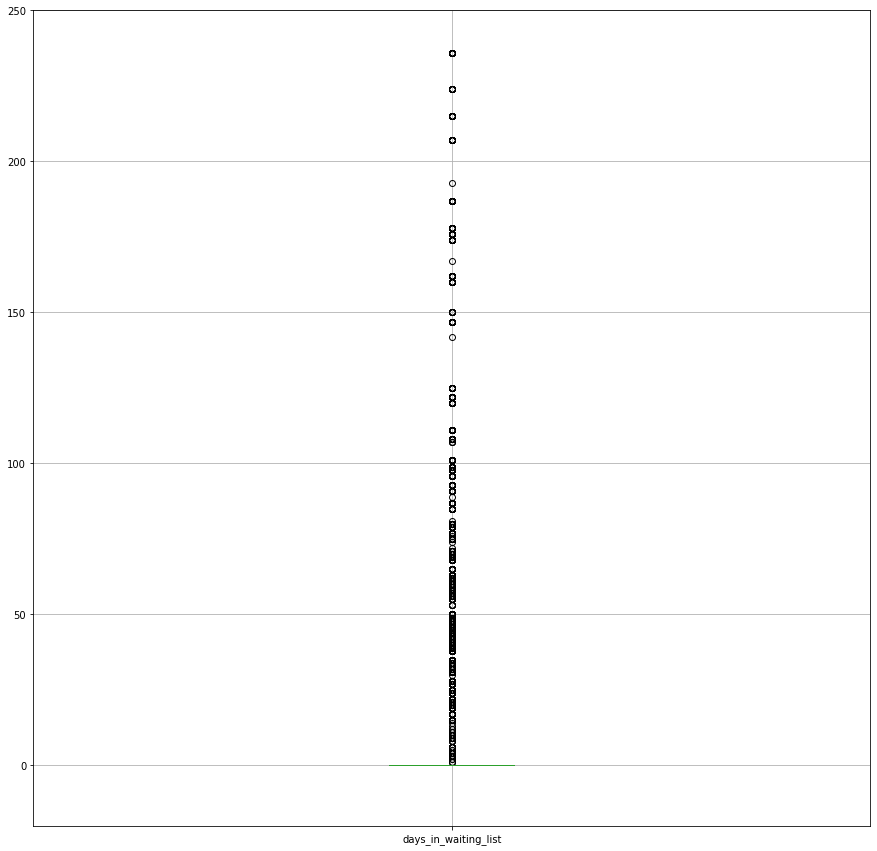

In [57]:
plt.ylim(-20,250)
hotel_train.boxplot('days_in_waiting_list')
plt.show()

In [58]:
len(hotel_train.query('days_in_waiting_list > 150'))

292

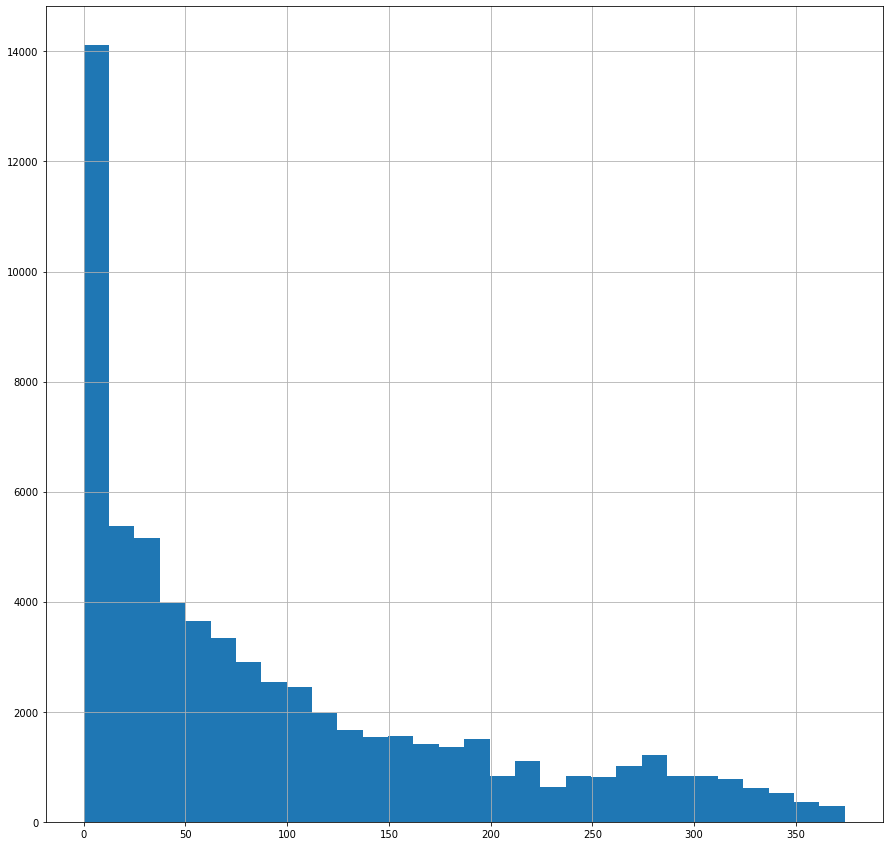

In [59]:
hotel_train['lead_time'].hist(bins=30)
plt.show()

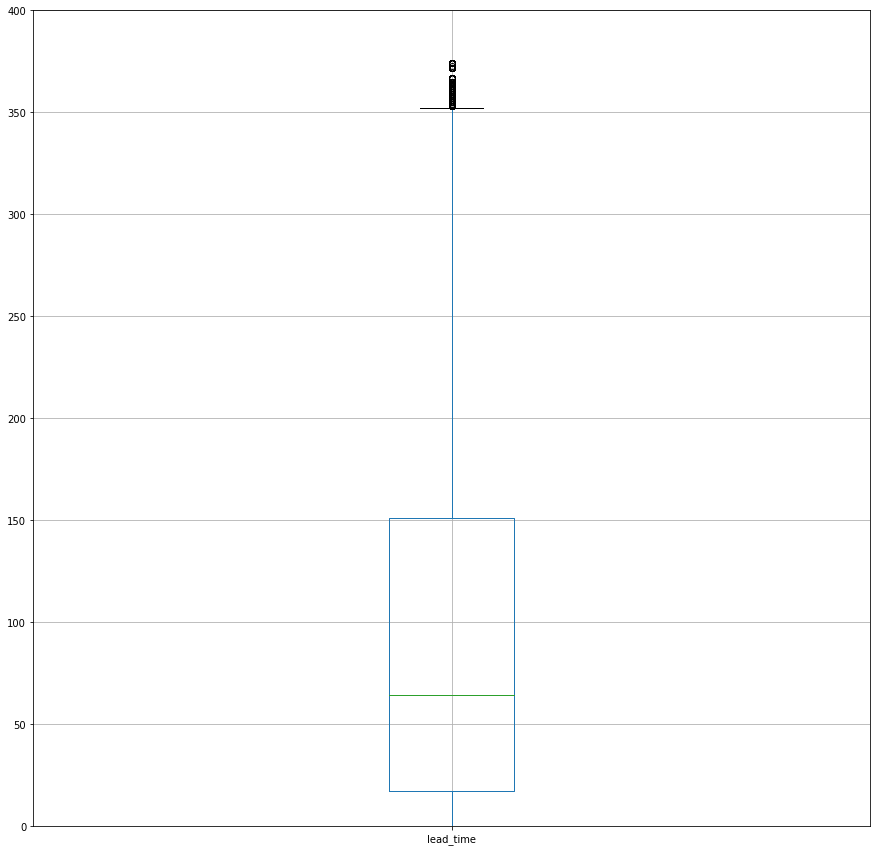

In [60]:
plt.ylim(0,400)
hotel_train.boxplot('lead_time')
plt.show()

In [61]:
len(hotel_train.query('lead_time > 350'))

567

**Проверим выбросы на тестовой выборке:**

In [62]:
hotel_test.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32403.000000,32403.000000,32403.0,32403.000000,32403.00000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000
mean,0.388575,97.607135,2017.0,17.806715,15.65531,1.858562,0.083634,0.005524,0.031263,0.011604,0.171342,0.216677,0.258649,0.045304,0.657748,3.208005
std,0.487434,86.508686,0.0,9.176954,8.76618,0.489404,0.343148,0.075768,0.174029,0.180498,1.875374,0.640575,4.685120,0.207974,0.834352,1.738738
min,0.000000,0.000000,2017.0,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,2017.0,10.000000,8.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,76.000000,2017.0,18.000000,15.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,155.000000,2017.0,25.000000,23.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,2017.0,35.000000,31.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,1.000000,5.000000,10.000000


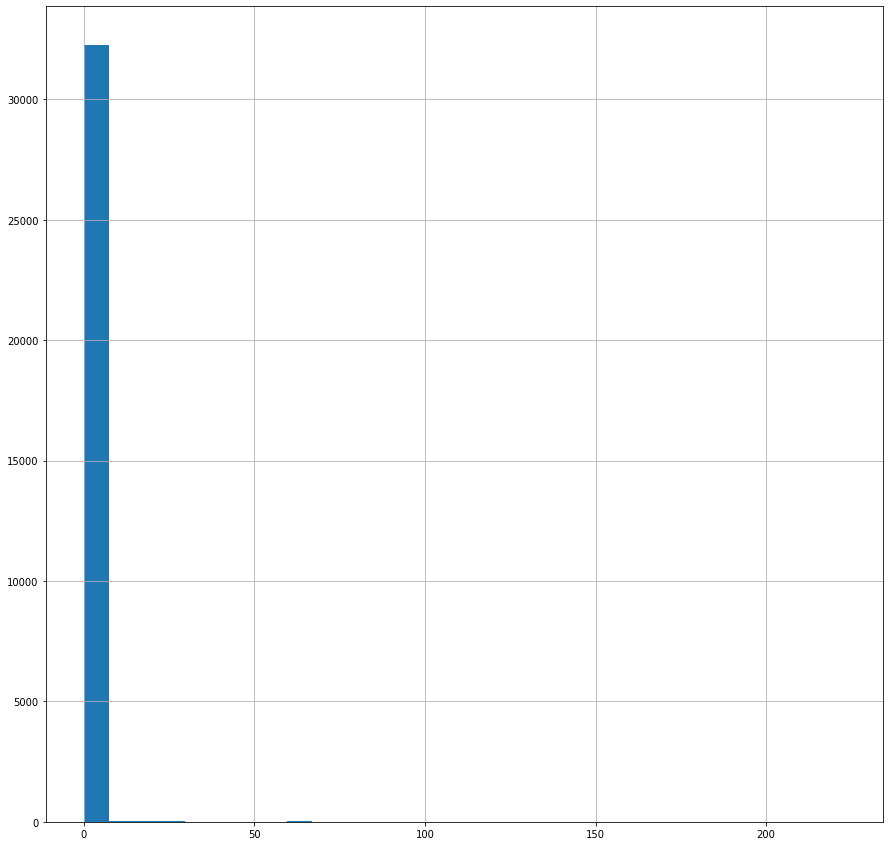

In [63]:
hotel_test['days_in_waiting_list'].hist(bins=30)
plt.show()

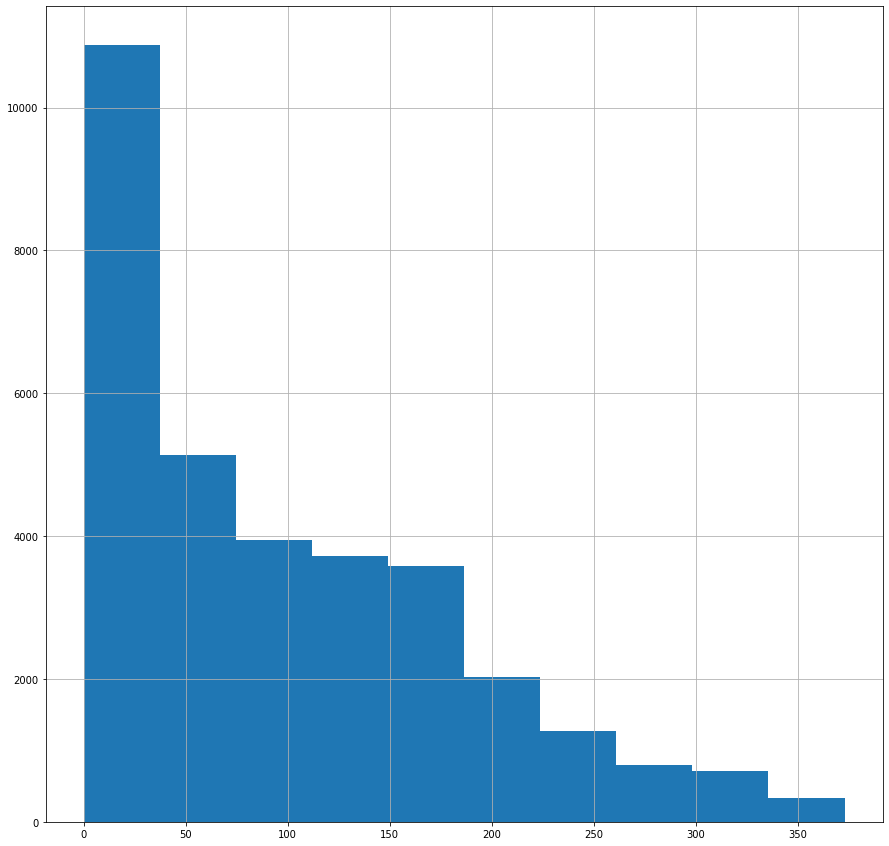

In [64]:
hotel_test['lead_time'].hist()
plt.show()

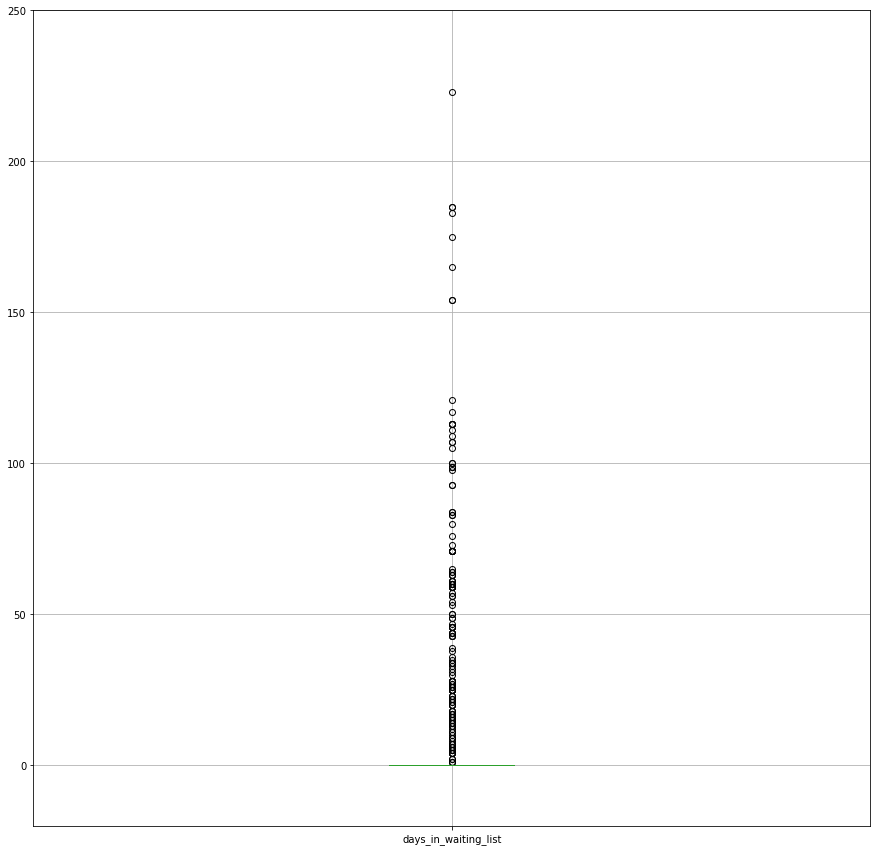

In [65]:
plt.ylim(-20,250)
hotel_test.boxplot('days_in_waiting_list')
plt.show()

In [66]:
len(hotel_test.query('days_in_waiting_list > 150'))

8

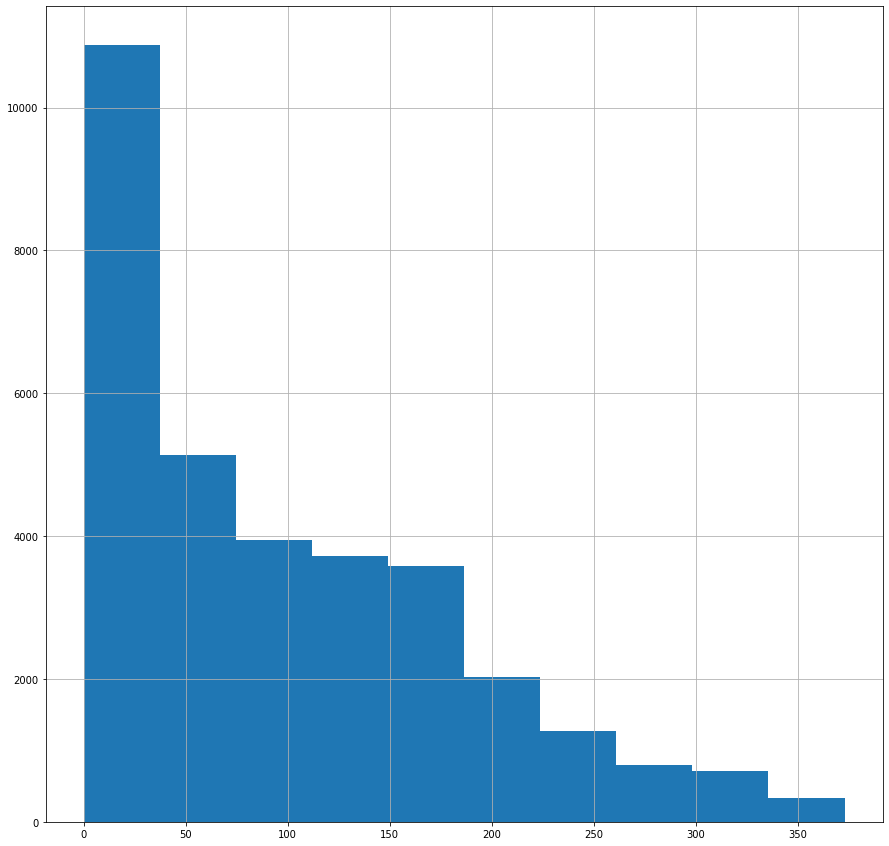

In [67]:
hotel_test['lead_time'].hist()
plt.show()

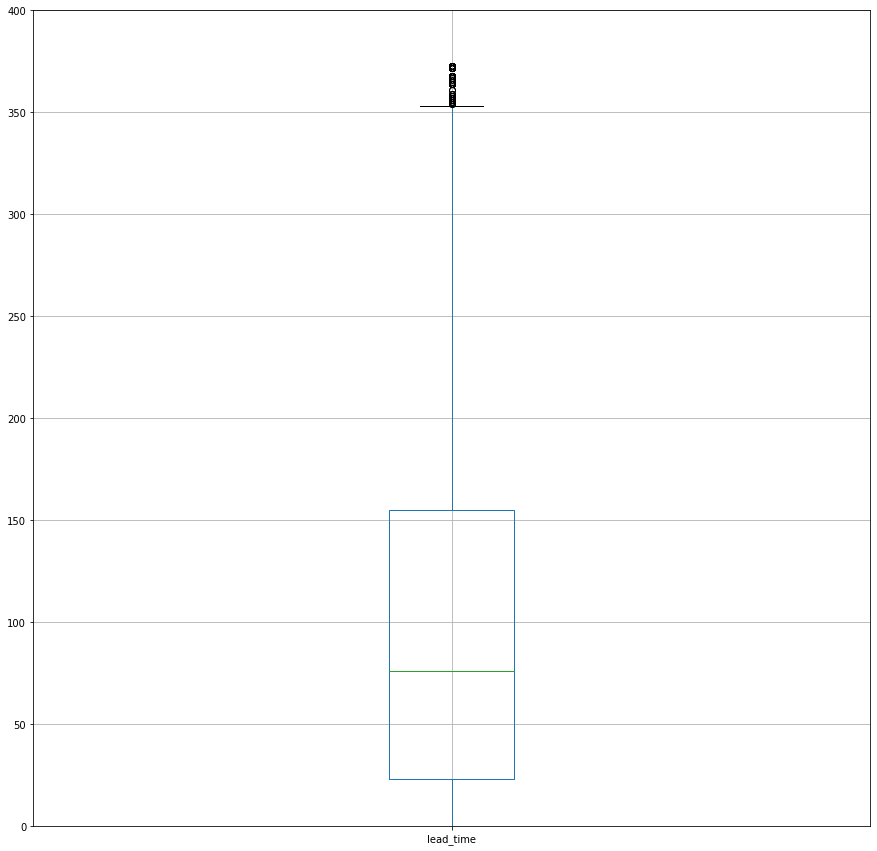

In [68]:
plt.ylim(0,400)
hotel_test.boxplot('lead_time')
plt.show()

In [69]:
len(hotel_test.query('lead_time > 350'))

187

Для задач машинного обучения данные в выборке не должны по возможности содержать выбросов и быть максимально стандартизированы, но в нашем случае мы оставим выбросы, так как они не значительны и есть в обеих таблицах.

**Итак, у нас имеется два дата-сета: первый для обучения модели; второй для итогового тестирования разработанной модели.**

**В датасетах:**

- пропуски не обнаружены
- заменили типы данных в колонках 'children','adults','babies' на int
- дубликаты обнаружены, однако решено их оставить
- аномалии, обработаны, категориалные признаки проверяны на предмет лишних пробелов и неявных дубликатов;
- исходный набор данных предоставляет дату прибытия клиента с указанием дня, месяца и года, каждый в отдельной функции. Для целей анализа объединили все эти элементы в одну функцию arrival_date_full
- В уникальных значениях колонки required_car_parking_spaces — количество мест для автомобилей увидели выбивающееся значения. Удалили их из-за маленького количества данных. 
- total_nights — это сумма stays_in_week_nights и stays_in_weekend_nights, поэтому удалили эти два столбца

**Исследовали целевой признака (is_canceled):**

- Примерно 30% бронированний было отменено
- Количество дней между датой бронирования и датой прибытия (lead time) наиболее тесно связано с тем, отменено бронирование или нет.
- Интересно, что количество специальных отметок (total_of_special_requests) является второй функцией, которая наиболее сильно коррелирует с отменой бронирования. По мере увеличения количества особых запросов вероятность отмены бронирования уменьшается. 
- Необходимость места для автомобиля (requires_car_parking_spaces) является третьим признаком, который наиболее сильно коррелирует с отменой бронирования. 
- Количество изменений параметров заказа (booking_changes) так же коррелирует с отменой. 
- Так же можно заметить, что предыдущая история отмены бронирования клиента (измеряемая количеством предыдущих отмен(previous_cancellations)) в большей степени коррелирует с тем, будет ли отменено текущее бронирование, чем предыдущая история клиента с отелем (измеряемая количеством предыдущих бронирований, которые не были отменены (previous_bookings_not_canceled), независимо от того, является ли клиент постоянным гостем(is_repeated_guest)

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

**Составим бизнес-модель отеля. Оценим его выручку без внедрения депозитов.**

Наша цель - построить модель, способную с максимальной точностью предсказать, будет ли отменено бронирование или нет. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%. На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**Бизнес-модель и другие данные**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на разовое обслуживание: как при подготовке номера, так и при проживании постояльца. В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

*Стоимость номеров отеля:*

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.


Расчет прибыли будем считать на дата-сете hotel_test, но для расчетов сохраним его в отдельной переменной hotel_profit:

In [70]:
hotel_profit = hotel_test

Оставим в hotel_profit только те колонки, которые пригодятся нам для расчета прибыли, остальные удалим:

In [71]:
hotel_profit.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month', 'adults',
       'children', 'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'arrival_date_full'],
      dtype='object')

In [72]:
hotel_profit = hotel_profit.drop(['lead_time', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes',
       'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests'], axis=1).reset_index()


In [73]:
display(hotel_profit.head(2))

,index,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,arrival_date_full
0,0,1,2017,January,1,1,A,1,2017-01-01
1,1,1,2017,January,1,1,A,4,2017-01-01


**Согласно заданию:**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

**Стоимость номеров отеля:**

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


Создаём словари для стоимости за одну ночь, затраты на уборку, сезонных коэффициентов

In [74]:
room_data = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],

'room_price': [1000, 800, 600, 550, 500, 450, 350],

'room_prepare': [400, 350, 350, 150, 150, 150, 150]})
display(room_data)

coef_seas = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June',

'July', 'August', 'September','October', 'November', 'December'],

'season_coeff': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0],

'n_month': [1,2,3,4,5,6,7,8,9,10,11,12]})
display(coef_seas)

,reserved_room_type,room_price,room_prepare
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


,arrival_date_month,season_coeff,n_month
0,January,1.0,1
1,February,1.0,2
2,March,1.2,3
3,April,1.2,4
4,May,1.2,5
5,June,1.4,6
6,July,1.4,7
7,August,1.4,8
8,September,1.2,9
9,October,1.2,10


In [75]:
hotel_profit = hotel_profit.merge(coef_seas, on='arrival_date_month', how='left')
hotel_profit = hotel_profit.merge(room_data, on='reserved_room_type', how='left')
display(hotel_profit.head(2))

,index,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,arrival_date_full,season_coeff,n_month,room_price,room_prepare
0,0,1,2017,January,1,1,A,1,2017-01-01,1.0,1,1000,400
1,1,1,2017,January,1,1,A,4,2017-01-01,1.0,1,1000,400


Создадим функцию, которая будет подсчитывать прибыль отеля без внедрения депозитов:

In [76]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['total_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
   
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    
    if (row['is_canceled'] == 0):
        
        prepare_nights = 1 + total_nights//2
        
        
        if (month in summer):
            revenue = 1.4*price*total_nights  - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_nights*prepare_cost
    else:
        if (month in summer):
            revenue = - (prepare_cost+1.4*price)

        elif (month in winter):
            revenue = - (prepare_cost+price)
        else:
            revenue =  - (prepare_cost+1.2 * price)
    return revenue
    

Рассчитаем суммарную прибыль отеля за все время до внедрения ML:

In [77]:
total_revenue = hotel_test.apply(count_revenue, axis=1).sum()
print(total_revenue)

32566680.0


### Шаг 4. Разработка модели ML

#### Обученик разных моделей и оценка их качества кросс-валидацией

Определение целевого и обучающих признаков:
Так как нам нужно предсказать отмену брони - целевым признаком будет колонка is_canceled. Остальное - обучающие признаки:

In [78]:
features_train = hotel_train.drop(['is_canceled'], axis=1) 
target_train = hotel_train['is_canceled']

features_test = hotel_test.drop(['is_canceled'], axis=1) 
target_test = hotel_test['is_canceled']

print('Размер тренировочной выборки: ', features_train.shape)
print('Размер target тренировочной выборки: ', target_train.shape)

print('Размер тестовой выборки: ', features_test.shape)
print('Размер target тестовой выборки: ', target_test.shape)

Размер тренировочной выборки:  (65215, 22)
Размер target тренировочной выборки:  (65215,)
Размер тестовой выборки:  (32403, 22)
Размер target тестовой выборки:  (32403,)


Оценка баланса классов:

In [79]:
target_train.value_counts(normalize=True)

0    0.631312
1    0.368688
Name: is_canceled, dtype: float64

Соотношение классов в целевом признаке примерно 60/40. Мы имеем дисбаланс классов.

Применим технику OneHotEncoder, чтобы преобразовать категориальные переменные в количественные.

In [80]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(features_train)
features_train = encoder.transform(features_train) 
features_test= encoder.transform(features_test)

Далее обучим модели и оценим их качество кросс-валидацией. Для решения задачи классификации подойдут 3 модели: логистическая регрессия, решающее дерево и случайный лес. Начнем с логистической регрессии:


Для нас важно чтобы наша модель предсказывала что клиент отменит бронь, важна метрика Recall (is_canceled = 1, predictions = 0) и (is_canceled = 1, predictions = 1):

Когда is_canceled = 1, predictions = 0 мы теряем 100%
Когда is_canceled = 1, predictions = 1 мы экономим 80%

Будем использовать recall ведь именно она позволит максимизировать прибыль, roc_auc, так как на нее не влияет дисбаланс классов

In [81]:
# Попробуем подобрать параметры для 
# Логистическая регрессия
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model_lg = LogisticRegression(solver='liblinear',random_state=12345)

grid_search = GridSearchCV(model_lg, par_grid_logist, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall')
grid_search.fit(features_train , target_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             refit='recall', scoring=['roc_auc', 'recall'])

In [82]:
grid_search.best_params_

{'C': 0.5, 'class_weight': 'balanced', 'intercept_scaling': 0.5}

In [83]:
print(grid_search.best_score_)

0.5430478557087048


In [84]:
grid_search.cv_results_

{'mean_fit_time': array([0.85161066, 0.84193239, 0.82893257, 0.88856931, 0.94648471,
        1.10060978, 1.05469875, 1.00884047, 1.06552067, 1.22585731,
        1.1602088 , 1.15995994, 1.19110894, 1.24088202, 1.17283835,
        1.29517918, 1.32469711, 1.2572145 ]),
 'std_fit_time': array([0.05634658, 0.0291397 , 0.06803672, 0.07056991, 0.12846395,
        0.17551602, 0.13058418, 0.11371601, 0.09606743, 0.10661827,
        0.09511171, 0.07071848, 0.08365971, 0.06534703, 0.10752675,
        0.11116947, 0.20781877, 0.12232726]),
 'mean_score_time': array([0.01091056, 0.01283765, 0.01109405, 0.01161485, 0.01162739,
        0.01825643, 0.01120777, 0.01105585, 0.01306744, 0.014258  ,
        0.01203756, 0.01418476, 0.01189084, 0.01165032, 0.01293449,
        0.01219354, 0.01173863, 0.01136417]),
 'std_score_time': array([0.00075845, 0.00238728, 0.00079447, 0.00120464, 0.00175662,
        0.0136509 , 0.00184267, 0.00085705, 0.00183704, 0.0024076 ,
        0.00112082, 0.0013408 , 0.00176376, 

Теперь перейдем к модели решающего дерева. Переберем гиперпараметры (размер глубины), и выведем на экран при какой глубине результат кросс-валидации дал наивысшую оценку качества модели:

In [85]:
# Модель дерево решений
par_grid_DT = {
                     'criterion': ['gini', 'entropy'],
                     'max_depth': np.arange(1, 10)
              }
model_grid_DT = DecisionTreeClassifier(random_state=12345)

grid_search = GridSearchCV(model_grid_DT, par_grid_DT, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall'
                          )
grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             refit='recall', scoring=['roc_auc', 'recall'])

In [86]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 3}

In [87]:
print(grid_search.best_score_)

0.607718741101422


In [88]:
grid_search.cv_results_

{'mean_fit_time': array([0.05763478, 0.07653451, 0.10696135, 0.14101014, 0.18106751,
        0.23679228, 0.32100511, 0.41347804, 0.53739619, 0.05593042,
        0.06784582, 0.09549274, 0.12584043, 0.17048268, 0.22138453,
        0.29037576, 0.38170104, 0.49525003]),
 'std_fit_time': array([0.00636501, 0.00988441, 0.00457251, 0.00856512, 0.01126033,
        0.02144052, 0.03798939, 0.03706619, 0.06691935, 0.00476858,
        0.00641338, 0.00728757, 0.01226935, 0.02379629, 0.0232601 ,
        0.02515176, 0.04811876, 0.07677817]),
 'mean_score_time': array([0.01243272, 0.01399837, 0.01427889, 0.01353741, 0.01231489,
        0.01318712, 0.01391912, 0.01533313, 0.01253309, 0.01442027,
        0.01279955, 0.01178088, 0.01348901, 0.01350398, 0.01160865,
        0.0120676 , 0.0127769 , 0.01451225]),
 'std_score_time': array([0.00254073, 0.0012078 , 0.00142953, 0.0014776 , 0.00132714,
        0.00162683, 0.00174325, 0.00100426, 0.00062904, 0.00198761,
        0.00162853, 0.00015823, 0.00261339, 

Теперь перейдем к модели случайного леса. Аналогично работе с предыдущей моделью, в цикле переберем значения гиперпараметра n_estimators, который отвечает за количество деревьев в лесу. Выведем на экран значение n_estimators при котором возможно получить максимальную оценку качества модели, полученную кросс-валидацией:

In [89]:
# Модель случайный лес
par_grid_ensemble = {'n_estimators': [3, 10],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 10)
                    }
model_RF = RandomForestClassifier(random_state=12345)

grid_search = GridSearchCV(model_RF, par_grid_ensemble, cv=5,
                           scoring=['roc_auc', 'recall'],
                           refit='recall'
                          )
grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 10),
                         'n_estimators': [3, 10]},
             refit='recall', scoring=['roc_auc', 'recall'])

In [90]:
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 7, 'n_estimators': 3}

In [91]:
print(grid_search.best_score_)

0.38641356040341723


In [92]:
grid_search.cv_results_

{'mean_fit_time': array([1.7654911 , 6.01790175, 1.70488262, 5.79294944, 1.7170485 ,
        5.52305484, 1.59236016, 5.30210328, 1.54690628, 5.12462912,
        1.80660586, 5.93282857, 1.59674702, 5.33975272, 1.56538401,
        5.00043459, 1.4508522 , 4.94964638, 1.49514403, 4.73204198]),
 'std_fit_time': array([0.10374267, 0.43850955, 0.10137851, 0.31361274, 0.06811109,
        0.26328853, 0.04127642, 0.24670988, 0.07895418, 0.25648557,
        0.07990905, 0.25680003, 0.09877855, 0.31559292, 0.08132943,
        0.24205726, 0.08574465, 0.2205976 , 0.05437608, 0.14193486]),
 'mean_score_time': array([0.03250246, 0.0859313 , 0.0311049 , 0.08130956, 0.03261981,
        0.07974606, 0.0337564 , 0.08374352, 0.03312006, 0.0824224 ,
        0.03509312, 0.07987556, 0.03076882, 0.077005  , 0.03254323,
        0.0735343 , 0.03176074, 0.07745862, 0.0306911 , 0.07575693]),
 'std_score_time': array([0.00406343, 0.00586029, 0.00127831, 0.00355223, 0.00282299,
        0.00464599, 0.0042343 , 0.006102

In [93]:
print('Логистическая регрессия:', 0.54)
print('Модель дерево решений:', 0.61)
print('Модель случайный лес:', 0.39)


Логистическая регрессия: 0.54
Модель дерево решений: 0.61
Модель случайный лес: 0.39


Модель дерево решений лучшая.Теперь проверим ее на тестовой выборке. 

#### Выбор лучшей модели и проверка её на тестовой выборке. 

In [94]:
model_grid_DT .fit(features_train, target_train)
predicted = model_grid_DT.predict(features_test)

roc_auc_test = roc_auc_score(target_test, predicted)
recall = recall_score(target_test, predicted)

print("ROC_auc")
print("Test set:", roc_auc_test)
print("Recall:", recall)

ROC_auc
Test set: 0.6702373949627332
Recall: 0.4721626558653006


Таким образом, модель  показывает на тестовой выборке следующие результаты:
ROC_auc Test set: 0.6702373949627332
Recall: 0.4721626558653006

#### Оценка прибыли, которую модель принесет за год

Сохраним предсказания модели в таблице hotel_test:

In [95]:
hotel_test['predictions'] = predicted
display(hotel_test.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_full,predictions
0,1,74,2017,January,1,1,2,0,0,BB,...,0,A,0,0,Transient,0,0,1,2017-01-01,1
1,1,62,2017,January,1,1,2,0,0,BB,...,0,A,0,0,Transient,0,1,4,2017-01-01,0
2,1,62,2017,January,1,1,2,0,0,BB,...,0,A,0,0,Transient,0,1,4,2017-01-01,0
3,1,71,2017,January,1,1,1,0,0,BB,...,0,A,0,0,Transient,0,1,4,2017-01-01,0
4,1,172,2017,January,1,1,2,0,0,BB,...,0,A,0,0,Transient,0,0,7,2017-01-01,1


Cоздадим функцию, которая подсчитает прибыль отеля с учетом введения депозитов:

In [96]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue_with_deposit(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    total_nights = row['total_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    
   
    deposit = 0.8*price+prepare_cost
    prepare_nights = 1 + total_nights//2
    
    
    if  (row['is_canceled'] == 0)&(row['predictions']==0):
        
        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_nights*prepare_cost
    
    elif  (row['is_canceled'] == 0)&(row['predictions']==1):
        
        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights  - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_nights*prepare_cost
        
    elif  (row['is_canceled'] == 1)&(row['predictions']==0):
        if (month in summer):
            revenue = - (prepare_cost+1.4*price)
        elif (month in winter):
            revenue = - (prepare_cost+price)
        else:
            revenue =  - (prepare_cost+1.2*price)
    
    
    elif (row['is_canceled'] == 1) & (row['predictions'] == 1):

        if (month in summer):
            revenue = - 0.2 * (prepare_cost + 1.4*price)
        
        elif (month in winter):
            revenue = - 0.2 *(prepare_cost+price)
        else:
            revenue = - 0.2 *(prepare_cost+1.2*price)
        
    return revenue

In [97]:
total_revenue_deposit = hotel_test.apply(count_revenue_with_deposit, axis=1).sum()
print(total_revenue_deposit)

39640328.0


Теперь подсчитаем чистую прибыль отеля после введения системы депозитов с учетом стоимости разработки системы прогнозирования:

In [98]:
IMPLEMENTATION_COST = 400000
net_profit = total_revenue_deposit  - total_revenue - IMPLEMENTATION_COST
print(net_profit) 

6673648.0


**Вывод**

- Отель до внедрения системы депозитов получил прибыль 32 566 680.0 млн.

- Лучшая модель - дерево решений
- Метрики качества на тестовой выборке следующие результаты: 
ROC_auc Test set: 0.6702373949627332
Recall: 0.4721626558653006


- Чистая прибыль после введения депозитов могла стать 39 640 328.0  млн

- C учетом стоимости введения системы депозитов, отель за год может получить дополнительно 6 673 648 млн. чистой прибыли

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проанализируем бронирования, которые модель посчитала отмененными и те, которые действительно ими оказались. Вызовем метод describe, чтобы сразу увидеть медианное значение и квартили:

In [99]:
hotel_test.query('is_canceled==1 and predictions==True').describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
count,5945.0,5945.000000,5945.0,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.0,5945.000000,5945.000000,5945.0
mean,1.0,132.385198,2017.0,18.968040,15.663751,1.907990,0.087973,0.001009,0.002019,0.004037,0.008410,0.058032,0.676030,0.0,0.123633,3.235156,1.0
std,0.0,81.485121,0.0,8.059314,8.826929,0.454651,0.359216,0.031755,0.044886,0.100389,0.291068,0.356392,7.095651,0.0,0.417108,1.468103,0.0
min,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
25%,1.0,62.000000,2017.0,14.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,1.0
50%,1.0,129.000000,2017.0,19.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000,1.0
75%,1.0,175.000000,2017.0,25.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000,1.0
max,1.0,373.000000,2017.0,35.000000,31.000000,4.000000,3.000000,1.000000,1.000000,4.000000,14.000000,6.000000,183.000000,0.0,4.000000,10.000000,1.0


На основе медиан и значений квартилей можно сказать, что "ненадежный" клиент:

- бронирует номер заранее, в основном - за 120 дней

- это двое взрослых без детей и младенцев

- никогда не был клиентом отеля, не отменял и не заказывал номера ранее

- не указывает специальные отметки, не вносит правки в бронь

- не запрашивает парковочное место

- бронирует в основном номер на 3 ночи

Проанализируем столбцы, содержащие категориальные переменные:

In [100]:
hotel_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True)

Transient          0.981497
Transient-Party    0.017157
Contract           0.001346
Name: customer_type, dtype: float64

В 94% случаев тип ненадежного клиента не связан с с договором или групповым заездом.

In [101]:
hotel_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True)

BB    0.808915
SC    0.138604
HB    0.050631
FB    0.001850
Name: meal, dtype: float64

В 81 % случаев выбирают только завтраки, в 12 % - ничего.

In [102]:
hotel_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True)

A    0.801850
D    0.137763
E    0.026577
F    0.012784
G    0.010597
B    0.005214
C    0.005214
Name: reserved_room_type, dtype: float64

В 79 % ненадежные клиенты предпочитают номера типа А

In [103]:
hotel_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True)

TA/TO        0.969722
Direct       0.019176
Corporate    0.011102
Name: distribution_channel, dtype: float64

Канал дистрибуции заказа в 99 % TA/TO  

**Вывод
Портрет ненадежного клиента выглядит следующим образом:**

- бронирует номер заранее, в основном - за 120 дней

- это двое взрослых без детей и младенцев

- никогда не был клиентом отеля, не отменял и не заказывал номера ранее

- не указывает специальные отметки, не вносит правки в бронь

- не запрашивает парковочное место

- бронирует в основном номер на 3 ночи

- не связан с договором или групповым заездом

- вместе с номером выбирает включенный в стоимость завтрак или ничего

- выбирает самый дорогую по стоимости категорию номера (А)

- канал дистрибуции - TA/TO

### Шаг 6. Напишите общий вывод

**Итак, изучив полученные данные,обработали их и подготовили к исследованию. Произвели преобразование категориальных признаков. Изучили целевой признак, удалили ненужные столбцы. Изучили корреляцию, заметили, что наибольшая корреляция наблюдается у целевого признака с количеством дней между датой бронирования и датой прибытия, количеством специальных отметок, необходимостью места для автомобиля. Наблюдается дисбаланс классов. 

*Составили бизнес-модель отеля. Оценили его выручку без внедрения депозитов.*

- Суммарная прибыль отеля до внедрения ML: 32 566 680.0 млн.

**Определили целевой и обучающий признаки. Преобразовали категориальные переменные в количественные. Обучили модели и оценили их качество кросс-валидацией: логистическую регрессию, решающее дерево и случайный лес. . Таким образом, лучшая модель - дерево решений

- Метрики качества на тестовой выборке следующие результаты: 
ROC_auc Test set: 0.6702373949627332
Recall: 0.4721626558653006


**Оценили прибыль, которую модель принесет за год**
**Вывод**

- Чистая прибыль после введения депозитов могла стать 39 640 328 млн

- C учетом стоимости введения системы депозитов, отель за год может получить дополнительно 6 673 648  млн. чистой прибыли



**Портрет ненадежного клиента выглядит следующим образом:**

- бронирует номер заранее, в основном - за 120 дней

- это двое взрослых без детей и младенцев

- никогда не был клиентом отеля, не отменял и не заказывал номера ранее

- не указывает специальные отметки, не вносит правки в бронь

- не запрашивает парковочное место

- бронирует в основном номер на 3 ночи

- не связан с договором или групповым заездом

- вместе с номером выбирает включенный в стоимость завтрак или ничего

- выбирает самый дорогую по стоимости категорию номера (А)

- канал дистрибуции - TA/TO

**Рекомендации:**

- 1) ввести систему депозитов

- 2) использовать модель для предсказания отказа от брони

- 3) вне зависимости от работы модели ввести обязательный депозит для клиентов, которые бронируют номера больше, чем за 4 месяца.
